# Ex1-high dimensional
The state is 50 dimensional, each feature of which is a binary variable.   
Denote the first feature of the  state variable as $x_1$. 
The reward obtained when transitioning from state in which $x_1=1$ is distributed as N (2, 1), and the reward obtained when transitioning from state in which $x_1=2$ is distributed as N (1, 1).    
The action space is $\{0,1\}$ which is an indicator of transfering $x_1$ of the current state to $2$.  
The behaviour policy specifies the probabilities of transferring from $x_1=1$ to $x_1=2$ and $x_1=2$ to $x_1=1$ are 0.4 and 0.8, respectively. The rest features, i.e., $x_2,\ldots,x_{49},x_{50}$, are binary variables that are drawn uniformly from $\{1,2\}$.

In [1]:

import numpy as np
import math
import os
from multiprocessing import Pool
from sklearn.model_selection import train_test_split, GridSearchCV
import random
from joblib import Parallel, delayed
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import copy
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import KFold
from scipy.stats import norm
from torch.distributions import Categorical
from collections import deque
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
from sklearn.linear_model import LogisticRegression
import pandas as pd

In [2]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [3]:
##parameter setting
trans_mat=np.array([[0.6,0.4],[0.8,0.2]])
# trans_mat_new=np.array([[0.5,0.5],[0.7,0.3]])
trans_mat_new=trans_mat

In [4]:
#################################
###### move one step forward ####
#################################

# behaviour policy
def step(last_obs):
    # last_obs: last observation of state
    s_next = np.zeros(50, dtype=int)
    if last_obs[0] == 1:
        a = np.random.binomial(1, p=trans_mat[0,1])  # ation: wheter to transition to x1=2
        r = np.random.normal(2, 1)  # reward at the same stage
        ## next state
        s_next[0] = a + 1  
        s_next[1:51] = np.random.binomial(1, p=0.5,size=49) + 1
    elif last_obs[0] == 2:
        a = np.random.binomial(1, p=trans_mat[1,1])
        r = np.random.normal(-1, 1)
        ## next state
        s_next[0] = a + 1
        s_next[1:50] = np.random.binomial(1, p=0.5,size=49) + 1

    return (a, r, s_next)


def step_new(last_obs):
    # last_obs: last observation of state
    s_next = np.zeros(50, dtype=int)
    if last_obs[0] == 1:
        a = np.random.binomial(1, p=trans_mat_new[0,1])  # ation: wheter to transition to x1=2
        r = np.random.normal(2, 1)  # reward at the same stage
        ## next state
        s_next[0] = a + 1  
        s_next[1:51] = np.random.binomial(1, p=0.5,size=49) + 1
    elif last_obs[0] == 2:
        a = np.random.binomial(1, p=trans_mat_new[1,1])
        r = np.random.normal(-1, 1)
        ## next state
        s_next[0] = a + 1
        s_next[1:50] = np.random.binomial(1, p=0.5,size=49) + 1

    return (a, r, s_next)

In [5]:
#################################
#### generate one trajectory ####
#################################


def gen_traj(T, gam, seed=None, s_init=None):
    # seed: random seed
    # s_init: initial state
    # gam: discount
    # T: iterative number

    # initialize the state
    s = np.zeros(50, dtype=int)
    if seed is None and s_init is None:
        s[0] = np.random.binomial(1, p=0.5) + 1
        s[1:50] = np.random.binomial(1, p=0.5,size=49) + 1
    elif seed is not None:
        np.random.seed(seed)
        s[0] = np.random.binomial(1, p=0.5) + 1
        s[1:50] = np.random.binomial(1, p=0.5,size=49) + 1
    if s_init is not None:
        s = s_init
    
    s_traj = np.zeros((T+1,50), dtype=int)
    s_traj[0][0:50] = s
    a_traj = []
    r_traj = []

    ret = 0
    for i in range(T):
        a, r, s_next = step(s)
        s_traj[i+1][0:50] = s_next
        a_traj.append(a)
        r_traj.append(r)
        s = s_next  # update current S as S_next
        ret += r * gam**i

    ## output state, reward trajectory. return
    return [s_traj, a_traj, r_traj, ret]




In [6]:
#######################
#### generate data ####
#######################

# on-policy
def data_gen(N, T_obs, T, gam, seed=None, s_init=None):
    # N: number of trajectories
    # T_obs: observed stage numbers

    s_data = np.zeros((N, T_obs,50), dtype=int)
    a_data = np.zeros((N, T_obs), dtype=int)
    r_data = np.zeros((N, T_obs))
    ret_data = []

    for i in range(N):
        if seed is not None:
            seed += 1
        tmp = gen_traj(T, gam, seed, s_init)
        s_data[i][0:T_obs][0:50] = tmp[0][0:T_obs][0:50]  # store the i-th state trajectory
        a_data[i] = tmp[1][0:T_obs]
        r_data[i] = tmp[2][0:T_obs]  # store the i-th reward trajectory
        ret_data.append(tmp[3])

    ## output observed state, reward trajectory and true return
    ## the s_data is the state data, which is a tensor. The first axis is observation number, the second time, the third value of state.
    return [s_data, a_data ,r_data, ret_data]



In [7]:
data_gen(N=400,T_obs=30,T=70,gam=0.8)

[array([[[1, 2, 2, ..., 1, 2, 2],
         [1, 1, 2, ..., 2, 2, 2],
         [1, 2, 1, ..., 2, 1, 1],
         ...,
         [1, 1, 2, ..., 2, 2, 1],
         [2, 1, 1, ..., 2, 2, 1],
         [1, 1, 1, ..., 1, 2, 2]],
 
        [[1, 2, 1, ..., 2, 1, 2],
         [2, 1, 2, ..., 1, 1, 2],
         [1, 2, 1, ..., 2, 1, 1],
         ...,
         [1, 2, 1, ..., 2, 1, 1],
         [2, 1, 2, ..., 1, 2, 2],
         [1, 1, 2, ..., 1, 1, 2]],
 
        [[1, 1, 1, ..., 2, 2, 1],
         [1, 1, 2, ..., 1, 2, 1],
         [1, 1, 2, ..., 2, 1, 2],
         ...,
         [2, 2, 1, ..., 1, 2, 1],
         [2, 1, 2, ..., 1, 1, 2],
         [1, 2, 1, ..., 2, 1, 2]],
 
        ...,
 
        [[2, 1, 1, ..., 1, 1, 2],
         [1, 2, 1, ..., 2, 1, 2],
         [1, 2, 2, ..., 1, 2, 2],
         ...,
         [1, 1, 2, ..., 2, 1, 1],
         [2, 1, 2, ..., 1, 1, 2],
         [2, 1, 1, ..., 2, 1, 2]],
 
        [[2, 1, 2, ..., 1, 2, 1],
         [1, 2, 2, ..., 2, 2, 2],
         [1, 1, 2, ..., 2, 1, 2],

In [8]:
class QuantileNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, num_quantiles):
        super(QuantileNetwork, self).__init__()
        self.num_quantiles = num_quantiles
        self.action_dim = action_dim
        
        # Quantile output layer
        self.quantiles = nn.Linear(state_dim, action_dim * num_quantiles).to(device)
        
    def forward(self, x):
        # Convert input to tensor if needed and move to device
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(device)
        elif x.device != device:
            x = x.to(device)
            

        quantiles = self.quantiles(x)
        return quantiles.view(-1, self.action_dim, self.num_quantiles)

class BehaviorPolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_size=32):
        super(BehaviorPolicyNetwork, self).__init__()
        # Policy network architecture
        self.net = nn.Sequential(
            nn.Linear(state_dim, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, action_dim)
        ).to(device)
        
    def forward(self, x):
        # Convert input to tensor if needed and move to device
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x).to(device)
        elif x.device != device:
            x = x.to(device)
        return self.net(x)
    
    def get_probs(self, x):
        logits = self.forward(x)
        return torch.softmax(logits, dim=-1)

class QTD_Agent:
    def __init__(self, state_dim, action_dim, gamma, lr, num_quantiles, 
                 behavior_lr, beta, batch_size, pen_lambd):
        
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.num_quantiles = num_quantiles
        self.beta = beta
        self.device = device
        self.penal_para = pen_lambd 
        
        # Initialize networks and move to GPU
        self.net = QuantileNetwork(state_dim, action_dim, num_quantiles).to(device)
        self.target_net = QuantileNetwork(state_dim, action_dim, num_quantiles).to(device)
        self.target_net.load_state_dict(self.net.state_dict())
        
        self.behavior_policy = BehaviorPolicyNetwork(state_dim, action_dim).to(device)
        
        # Optimizers
        self.optimizer = optim.Adam(self.net.parameters(), lr=lr)
        self.behavior_optimizer = optim.Adam(self.behavior_policy.parameters(), lr=behavior_lr)
        
        # Replay buffer
        self.buffer = deque(maxlen=100000)
        self.batch_size = batch_size
        self.quantile_fractions = torch.linspace(0.5/num_quantiles, 1-0.5/num_quantiles, num_quantiles).to(device)

        # Learning rate scheduling
        self.scheduler=SequentialLR(self.optimizer,
            schedulers=[
                LinearLR(self.optimizer, start_factor=0.2, end_factor=1.0, total_iters=300),  # Warm-up phase
                CosineAnnealingLR(self.optimizer, T_max=700, eta_min=1e-5)                  # Main decay phase
            ],
            milestones=[300]  # Switch after 300 steps
                                   )                
        self.behavior__scheduler = LinearLR(self.behavior_optimizer, start_factor=1, end_factor=0.2, total_iters=3000)
 
    def get_target_policy_probs(self, states, actions=None):
        with torch.no_grad():
            # Define the transition matrix (convert from NumPy to PyTorch tensor)
            trans_mat = torch.from_numpy(trans_mat_new).to(device)
            
            # Get policy probabilities based on states
            
            states = states[:,0].long() - 1  # Convert to zero-based integer indices
            p = trans_mat[states, 1]  # Probability of transitioning to state 2
            
            # Construct action probability distribution
            probs = torch.stack([1-p, p], dim=1)
            
            if actions is not None:
                actions = actions.to(device)
            # Ensure actions has shape [batch_size, 1] for gathering
                if actions.dim() == 1:
                    actions = actions.unsqueeze(1)
                return probs.gather(1, actions)  # Shape [batch_size, 1]
        return probs  # Return full action probability distribution
    
    # Polyak averaging for target network update
    def update_target(self, tau):
        for target_param, param in zip(self.target_net.parameters(), self.net.parameters()):
            target_param.data.copy_(tau * param.data + (1-tau) * target_param.data)
    
    def store_transition(self, state, action, reward, next_state, done, behavior_prob):
        # Ensure we store Python scalars or NumPy arrays
        if isinstance(state, torch.Tensor):
            state = state.cpu().numpy()
        if isinstance(next_state, torch.Tensor):
            next_state = next_state.cpu().numpy()
        self.buffer.append((state, action, reward, next_state, done, behavior_prob))
    
    def train_behavior_policy(self, states, actions):
        probs = self.behavior_policy.get_probs(states)
        action_probs = probs.gather(1, actions.unsqueeze(1))
        loss = -torch.log(action_probs).mean()
        
        self.behavior_optimizer.zero_grad()
        loss.backward()
        self.behavior_optimizer.step()
        return loss.item()
    
    def pseudo_sample_next_actions(self, next_states):
        probs = self.get_target_policy_probs(next_states)
        probs = torch.clamp(probs, min=1e-5, max=1.0-1e-5)
        probs = probs / probs.sum(dim=-1, keepdim=True)
        actions = torch.multinomial(probs, num_samples=1)
        return actions.squeeze(-1)
        
    def get_quantiles_for_state(self, state, action=None):
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
            quantiles = self.net(state_tensor).squeeze(0)  # [action_dim, num_quantiles]
            
            if action is not None:
                return quantiles[action].cpu().numpy()
            return quantiles.cpu().numpy()

    def train(self):
        if len(self.buffer) < self.batch_size:
            return 0, 0
        
        # Sample batch from replay buffer
        batch = random.sample(self.buffer, self.batch_size)
        states, actions, rewards, next_states, dones, behavior_probs = zip(*batch)
        
        # Convert to tensors and move to GPU
        states = torch.FloatTensor(np.array(states)).to(device)
        actions = torch.LongTensor(np.array(actions)).to(device)
        rewards = torch.FloatTensor(np.array(rewards)).unsqueeze(-1).to(device)
        next_states = torch.FloatTensor(np.array(next_states)).to(device)
        dones = torch.FloatTensor(np.array(dones)).unsqueeze(-1).to(device)
        behavior_probs = torch.FloatTensor(np.array(behavior_probs)).unsqueeze(-1).to(device)
        
        # 1. Train behavior policy
        behavior_loss = self.train_behavior_policy(states, actions)
        
        # 2. Calculate importance weights
        with torch.no_grad():
            current_action_probs = self.get_target_policy_probs(states, actions)
            importance_weights = (current_action_probs / behavior_probs+ 1e-5).clamp(0, 1/self.beta)
        
        # 3. Get current quantile estimates
        current_quantiles = self.net(states)
        actions = actions.view(-1, 1, 1).expand(-1, -1, self.num_quantiles)
        current_quantiles = current_quantiles.gather(1, actions).squeeze(1)
        
        # 4. Compute target quantiles
        with torch.no_grad():
            next_actions = self.pseudo_sample_next_actions(next_states)
            next_actions = next_actions.view(-1, 1, 1).expand(-1, -1, self.num_quantiles)
            
            target_quantiles = self.target_net(next_states)
            target_quantiles = target_quantiles.gather(1, next_actions).squeeze(1)
            target_quantiles = rewards + self.gamma * target_quantiles * (1 - dones)
        
        # 5. Compute quantile regression loss
        diff = target_quantiles.unsqueeze(-1) - current_quantiles.unsqueeze(1)
        weight = torch.abs(self.quantile_fractions - (diff.detach() < 0).float())
        
        l2_reg = sum(p.pow(2).sum() for p in self.net.parameters())
        loss = torch.where(
            diff.abs() < 1,
            0.5 * diff.pow(2) * weight,
            (diff.abs() - 0.5) * weight
        ) 
        loss += 0.5 * self.penal_para * l2_reg
        loss = (loss * importance_weights.unsqueeze(-1)).mean()
    
        # 6. Optimize model
        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.net.parameters(), 2.0)
        self.optimizer.step()
        self.scheduler.step()
        
        return loss.item(), behavior_loss


In [9]:
####################################
### Quantile temperal difference ###
####################################


def QTD_new(state_traj,
        action_traj,
        reward_traj,
        state_dim,
        action_card,
        quantile_num,
        gam,
        seed,
        lr,
        behavior_lr,
        beta,
        batch_size,
        tau,
        lambd):

    agent = QTD_Agent(state_dim = state_dim, action_dim = action_card,gamma=gam,lr=lr,num_quantiles=quantile_num,behavior_lr=behavior_lr,
                      beta=beta,batch_size=batch_size,pen_lambd=lambd)
    n_tr=np.shape(state_traj)[0]
    T_obs=np.shape(state_traj)[1]
    for i in range(n_tr):
        for j in range(T_obs-1):
            with torch.no_grad():   
                state = state_traj[i,j]
                state_tensor = torch.FloatTensor(state).unsqueeze(0)
                action = action_traj[i,j]
                behavior_probs = agent.behavior_policy.get_probs(state_tensor)
                behavior_prob = behavior_probs[0, action].item()
                reward = reward_traj[i,j]
                next_state = state_traj[i,j+1]
                done=False
                behavior_prob = behavior_probs[0, action].item()
        
            agent.store_transition(state, action, reward, next_state, done, behavior_prob)
    for step in range(2001):
        loss, behavior_loss = agent.train()
        if step % 5 == 0:
            agent.update_target(tau=tau)
    return agent

In [10]:
n_tr = 400
gam = 0.8
T_obs = 30
seed = 2025
n_te = 310
T = 70
B = 50
alp = 0.1
tau = 0.1
quantile_num = 20
clip=np.array([0.2,5.0])
step_forward = [1, 2, 3,4,5]
sample_size=200
lr=0.006
behavior_lr=0.01
beta=0.5
batch_size=64
lambd=0.05

In [11]:
data_train = data_gen(N=n_tr,
                          T_obs=T_obs,
                          T=T,
                          gam=gam,
                          seed=seed,
                          s_init=None)


data_test = data_gen(N=n_te,
                         T_obs=1,
                         T=T,
                         gam=gam,
                         seed=seed + 10000,
                         s_init=None)

In [12]:
agent = QTD_new(state_traj=data_train[0],
                    action_traj=data_train[1],
                    reward_traj=data_train[2],
                    state_dim=50,
                    action_card=2,
                    quantile_num=quantile_num,
                    gam=gam,
                    seed=seed,
                    lr=lr,
                    behavior_lr=behavior_lr,
                    beta=beta,
                    batch_size=batch_size,
                    tau=tau,
                    lambd=lambd)

D:\Anaconda\envs\Pytorch\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


In [13]:
## calculate V estimator based on QTD output
def v_hat_f(state):
    q_hat = (np.mean(agent.get_quantiles_for_state(state), axis=1))
    v = (q_hat[0]*trans_mat_new[state[0]-1,0]+q_hat[1]*trans_mat_new[state[0]-1,1]).item()
    return v



In [14]:
def weight_calculation_clip(states, actions, clip):
    weight=1
    step=np.shape(states)[0]-1
    for i in range(step):
        state_tensor = torch.FloatTensor(states[i]).unsqueeze(0)
        behavior_probs = agent.behavior_policy.get_probs(state_tensor)
        behavior_prob = behavior_probs[0, actions[i]].item()
        weight*=trans_mat_new[states[i][0]-1,actions[i]]/behavior_prob
    weight=max(min(clip[1],weight),clip[0]) 
    return(weight)

In [15]:
def replay_buffer(s_traj, s_traj_train, a_traj, r_traj,step_forward,clip):
    n = np.shape(s_traj)[0]
    p = np.shape(s_traj)[1] - step_forward
    state_dim=np.shape(s_traj)[2]
#logistic regression
    s_b = s_traj_train[:,1:p].reshape(-1,state_dim)
    s_0 = s_traj_train[:,0]
    X = np.vstack([s_b,s_0])
    y = np.concatenate([np.ones(np.shape(s_b)[0]), np.zeros(np.shape(s_0)[0])])
    rt = 1/(p-1)
    model = LogisticRegression().fit(X, y)
    
    Mem_state = np.zeros((n*p,step_forward+1,state_dim))
    Mem_action = np.zeros((n*p,step_forward+1),dtype=int)
    Mem_reward = np.zeros((n*p,step_forward+1))
    idx_weight=[]
    state_zero=s_traj[:,0]
    for i in range(n):
        for j in range(p):
            Mem_state[(i*p+j),:] = s_traj[i,j:(j+step_forward+1)]
            Mem_action[(i*p+j),:] = a_traj[i,j:(j+step_forward+1)]
            Mem_reward[(i*p+j),:] = r_traj[i,j:(j+step_forward+1)]
            idx_weight.append(
            weight_calculation_clip(Mem_state[(i*p+j), :], Mem_action[(i*p+j), :],clip) * rt*model.predict_proba(np.expand_dims(Mem_state[(i*p+j), 0], axis=0))[0, 1]/model.predict_proba(np.expand_dims(Mem_state[(i*p+j), 0], axis=0))[0, 0]
            )

    total = np.array(idx_weight).sum()
    idx_weight_final=np.array(idx_weight)/total
    return([Mem_state,Mem_action,Mem_reward,idx_weight_final])



In [16]:

def weighted_percentile(data, weights, perc,method):

    data = np.array(data)
    weights = np.array(weights)
    idx = np.argsort(data)
    data = data[idx] # sort data
    weights = weights[idx] # sort weights
    cdf = np.cumsum(weights) / np.sum(weights)
    count = np.sum([ cdf[i] <= perc for i in range(np.shape(cdf)[0]) ])
    #if output=infty return the maximum of V
    if data[count]==float('inf') or method=="min":
        count-=1

        
    return(data[count])
    

In [17]:
def scoring(s_traj, r_traj,step_forward,gam,quan_num):
    # s_traj: state trajectory
    # r_traj: reward trajectory
    # step_forward: number of steps used in approximating return
    # gam: discount
    if np.shape(s_traj)[1]!=step_forward+1:
        print("length dismatch")
    if np.shape(s_traj)[0]!=np.shape(r_traj)[0]:
        print("height dismatch")
    
    n = np.shape(s_traj)[0]
    u = np.random.randint(0, quan_num - 1, size=n)
    sc = list(
        map(
            abs,
            np.sum([gam**i * r_traj[:, i] for i in range(step_forward)],
                   axis=0) +
            [
                gam**step_forward * agent.get_quantiles_for_state(s_traj[i, step_forward])[step_new(s_traj[i, step_forward])[0],u[i]] -
                v_hat_f(s_traj[i, 0] ) for i in range(n)
            ]))
    return (sc)

In [18]:
import itertools

In [19]:
def new_rb_res(data_train, data_test, gam, alp, step_forward, num_quantiles,B,eta,seed,sample_size,clip,action_card,lr,behavior_lr,beta,batch_size,tau,lambd):
    n_tr, n_te = np.shape(data_train[0])[0], np.shape(data_test[0])[0]
    s_init_te = data_test[0]
    a_init_te = data_test[1]
    ret_te = data_test[3]
    state_dim=np.shape(data_test[0])[2]
    
    ## split training data
    idx_perm = np.random.permutation(list(range(0, n_tr)))
    idx_tr, idx_cal = [idx_perm[0:int(n_tr / 2)], idx_perm[int(n_tr / 2):n_tr]]
    s_train_fold = data_train[0][idx_tr]
    a_train_fold = data_train[1][idx_tr]
    r_train_fold = data_train[2][idx_tr]
    
    ## train return distribution using QTD
    agent=QTD_new(state_traj=s_train_fold,
        action_traj=a_train_fold,
        reward_traj=r_train_fold,
        state_dim=state_dim,
        action_card=action_card,
        quantile_num=num_quantiles,
        gam=gam,
        seed=seed,
        lr=lr,
        behavior_lr=behavior_lr,
        beta=beta,
        batch_size=batch_size,
        tau=tau,
        lambd=lambd)

    def v_hat_f(state):
        state_idx = int(state[0]) - 1  # Convert to 0-based index
        q_hat = np.mean(agent.get_quantiles_for_state(state), axis=1)
        v = q_hat[0] * trans_mat_new[state_idx, 0] + q_hat[1] * trans_mat_new[state_idx, 1]
        return float(v)

    def weight_calculation_clip(states, actions, clip):
        weight = 1.0
        steps = states.shape[0] - 1
        
        for i in range(steps):
            state_tensor = torch.FloatTensor(states[i]).unsqueeze(0)
            behavior_probs = agent.behavior_policy.get_probs(state_tensor)
            
            # Ensure action is integer
            action_idx = int(actions[i])
            behavior_prob = behavior_probs[0, action_idx].item()
            
            # Ensure state index is integer
            state_idx = int(states[i][0]) - 1
            weight *= trans_mat_new[state_idx, action_idx] / behavior_prob
        
        return np.clip(weight, clip[0], clip[1])

    def replay_buffer(s_traj, s_traj_train, a_traj, r_traj,step_forward,clip):
        with torch.no_grad():
            n = np.shape(s_traj)[0]
            p = np.shape(s_traj)[1] - step_forward
            state_dim=np.shape(s_traj)[2]
        #logistic regression
            s_b = s_traj_train[:,1:p].reshape(-1,state_dim)
            s_0 = s_traj_train[:,0]
            X = np.vstack([s_b,s_0])
            y = np.concatenate([np.ones(np.shape(s_b)[0]), np.zeros(np.shape(s_0)[0])])
            rt = 1/(p-1)
            model = LogisticRegression().fit(X, y)
            
            Mem_state = np.zeros((n*p,step_forward+1,state_dim))
            Mem_action = np.zeros((n*p,step_forward+1),dtype=int)
            Mem_reward = np.zeros((n*p,step_forward+1))
            idx_weight=[]
            state_zero=s_traj[:,0]
            for i in range(n):
                for j in range(p):
                    Mem_state[(i*p+j),:] = s_traj[i,j:(j+step_forward+1)]
                    Mem_action[(i*p+j),:] = a_traj[i,j:(j+step_forward+1)]
                    Mem_reward[(i*p+j),:] = r_traj[i,j:(j+step_forward+1)]
                    idx_weight.append(
                    weight_calculation_clip(Mem_state[(i*p+j), :], Mem_action[(i*p+j), :],clip) * rt*model.predict_proba(np.expand_dims(Mem_state[(i*p+j), 0], axis=0))[0, 1]/model.predict_proba(np.expand_dims(Mem_state[(i*p+j), 0], axis=0))[0, 0]
                    )
        
            total = np.array(idx_weight).sum()
            idx_weight_final=np.array(idx_weight)/total
        return([Mem_state,Mem_action,Mem_reward,idx_weight_final])
    
    def scoring(s_traj, r_traj,step_forward,gam,quan_num):
    # s_traj: state trajectory
    # r_traj: reward trajectory
    # step_forward: number of steps used in approximating return
    # gam: discount
        with torch.no_grad():
            if np.shape(s_traj)[1]!=step_forward+1:
                print("length dismatch")
            if np.shape(s_traj)[0]!=np.shape(r_traj)[0]:
                print("height dismatch")
            
            n = np.shape(s_traj)[0]
            u = np.random.randint(0, quan_num - 1, size=n)
            sc = list(
                map(
                    abs,
                    np.sum([gam**i * r_traj[:, i] for i in range(step_forward)],
                           axis=0) +
                    [
                        gam**step_forward * agent.get_quantiles_for_state(s_traj[i, step_forward])[step_new(s_traj[i, step_forward])[0],u[i]] -
                        v_hat_f(s_traj[i, 0] ) for i in range(n)
                    ]))
        return (sc)
        
    with torch.no_grad():
    ## calculate nonconformity scores based on test set
        sc_te = [abs(ret_te[i] - v_hat_f(s_init_te[i, 0])) for i in range(n_te)]
        
        ## replay buffer
        l = np.shape(step_forward)[0]
        if isinstance(eta, int) == False:
            m = np.shape(eta)[0]
        elif isinstance(eta, int) == True:
            m = 1
            
        PI_cov_e = np.zeros((m,l))
        PI_len_e = np.zeros((m,l))
                
    
        for k in range(l):
            
           
            quan_B_e = np.zeros((m,n_te,B))
     
            for i in range(B):
                
            #n_cal = np.random.choice(a=[j for j in range(np.shape(Mem[0])[0])], p=p,size=200)
                Mem=replay_buffer(s_traj=data_train[0][idx_cal, :], s_traj_train=s_train_fold, a_traj=data_train[1][idx_cal, :], 
                             r_traj=data_train[2][idx_cal, :],step_forward=step_forward[k],clip=clip)
                
                weight_is=Mem[-1]
                n_cal = np.random.choice(range(np.shape(weight_is)[0]),size=sample_size, p=weight_is)
                ## calculate nonconformity scores based on calibration set
                sc_rb = scoring(s_traj=Mem[0][n_cal,],
                                r_traj=Mem[2][n_cal,],
                                step_forward=step_forward[k],
                                gam=gam,
                                quan_num=num_quantiles)
                sc_rb.append(float('inf')) 
                for j in range(n_te): 
                    for z in range(m):
                        quan_B_e[z][j,i] = weighted_percentile(data=sc_rb,weights=np.ones(sample_size+1),
                                                          perc=1-alp*eta[z],method="min")
                        
            critical_value_rb_e = np.zeros((m,n_te))
     
            for z in range(m):
                critical_value_rb_e[z,:] = [ np.percentile(a=quan_B_e[z][k,:],
                                                               q=eta[z]*100) for k in range(n_te) ]
    
                
                PI_cov_e[z,k] = np.mean([sc_te[k] <= critical_value_rb_e[z,k] 
                                             for k in range(n_te)])
                PI_len_e[z,k] = 2 * np.mean(critical_value_rb_e[z,:])
                
            
    return([PI_cov_e,PI_len_e])

In [20]:
def quantile_region_res(data_train, data_test, gam, alp, num_quantiles,seed,action_card,lr,behavior_lr,beta,batch_size,tau,lambd):

    n_tr, n_te = np.shape(data_train[0])[0], np.shape(data_test[0])[0]
    state_dim = np.shape(data_train[0])[2]
    s_init_te = data_test[0]
    a_init_te = data_test[1] 
    ret_te = data_test[3]
    quant_num = num_quantiles
    ## train QTD using full training data
    agent=QTD_new(state_traj=data_train[0],
        action_traj=data_train[1],
        reward_traj=data_train[2],
        state_dim=state_dim,
        action_card=action_card,
        quantile_num=num_quantiles,
        gam=gam,
        seed=seed,
        lr=lr,
        behavior_lr=behavior_lr,
        beta=beta,
        batch_size=batch_size,
        tau=tau,
        lambd=lambd)
    with torch.no_grad():
        data_t=data_test[0].reshape(-1,state_dim)
        quant_interval_lower=np.zeros(n_te)
        quant_interval_upper=np.zeros(n_te)
        ## lower and upper quanitles for each states 
        for i in range(n_te):
            data_aug=np.hstack((agent.get_quantiles_for_state(data_t[i])[0,:], agent.get_quantiles_for_state(data_t[i])[1,:])) 
            weight_aug=np.hstack((np.ones(quant_num)*trans_mat_new[data_t[i,0]-1,0]/quant_num,np.ones(quant_num)*trans_mat_new[data_t[i,0]-1,1]/quant_num))
            quant_interval_lower[i]=weighted_percentile(data_aug,weight_aug,alp/2,method="min")
            quant_interval_upper[i]=weighted_percentile(data_aug,weight_aug,1-alp/2,method="max")
                           
    
        ## calculate coverage
        t1 = [
        ret_te[i] >= quant_interval_lower[i] for i in range(n_te)
        ]
        t2 = [
        ret_te[i] <= quant_interval_upper[i] for i in range(n_te)
        ]
        quan_PI_cov = np.mean([all([t1[i], t2[i]]) for i in range(n_te)])
        quan_PI_len = np.mean(quant_interval_upper - quant_interval_lower
            )

    return ([quan_PI_cov, quan_PI_len])

In [21]:
#Parallel Calculation
#Parallel Calculation
def run_single_experiment(i, n_tr, gam, T_obs, seed, n_te, T, num_quantiles, B, alp, eta, step_forward,sample_size,clip,action_card,lr,behavior_lr,beta,batch_size,tau,lambd):

    data_train = data_gen(N=n_tr,
                          T_obs=T_obs,
                          T=T,
                          gam=gam,
                          seed=seed + i,
                          s_init=None)


    data_test = data_gen(N=n_te,
                             T_obs=1,
                             T=T,
                             gam=gam,
                             seed=seed + i + 10000,
                             s_init=None)

    result = new_rb_res(data_train=data_train,
                        data_test=data_test,
                        gam=gam,
                        alp=alp,
                        step_forward=step_forward,
                        num_quantiles=num_quantiles,
                        B=B,
                        eta=eta,
                        seed=seed + i,
                        sample_size=sample_size,
                       clip=clip,
                       action_card=action_card,
                       lr=lr,
                       behavior_lr=behavior_lr,
                       beta=beta,
                       batch_size=batch_size,
                       tau=tau,
                       lambd=lambd)
   
    return result  # return [PI_cov_e, PI_len_e]



In [ ]:
# Parameter setting
rep = 50
n_tr = 400
gam = 0.8
T_obs = 30
seed = 2025
n_te = 310
T = 70
num_quantiles = 30
B = 50
alp = 0.1
eta = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
clip=np.array([0.2,5.0])
step_forward = [1, 2, 3,4,5]
sample_size=200
action_card=2
lr=0.05
behavior_lr=0.005
beta=0.5
batch_size=64
tau=0.1
lambd=0.001



results = Parallel(n_jobs=13, verbose=1)(
    delayed(run_single_experiment)(
        i, n_tr, gam, T_obs, seed, n_te, T, num_quantiles, B, alp, eta, step_forward,sample_size,clip,action_card,lr,behavior_lr,beta,batch_size,tau,lambd
    ) for i in range(rep)
)




[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed: 137.7min finished


In [55]:
results

[[array([[0.93548387, 0.96774194, 0.97419355, 0.97419355, 0.97419355],
         [0.90645161, 0.9516129 , 0.96774194, 0.97419355, 0.97419355],
         [0.88709677, 0.94193548, 0.96774194, 0.97096774, 0.96774194],
         [0.88064516, 0.93225806, 0.95483871, 0.96774194, 0.96774194],
         [0.86451613, 0.92903226, 0.9483871 , 0.96774194, 0.96451613],
         [0.86451613, 0.92580645, 0.9483871 , 0.95483871, 0.95483871],
         [0.86451613, 0.90967742, 0.94516129, 0.95483871, 0.95483871]]),
  array([[8.2244556 , 9.16083324, 9.69972944, 9.9442224 , 9.92807247],
         [7.7521044 , 8.72994534, 9.2115843 , 9.72704669, 9.51949683],
         [7.56053859, 8.42084251, 9.07083761, 9.40777304, 9.22250554],
         [7.39161972, 8.19120468, 8.78681704, 9.19020734, 9.03727396],
         [7.27803691, 8.01848451, 8.63064506, 9.03849889, 8.98230576],
         [7.15243925, 7.95900045, 8.56897786, 8.81100347, 8.85498837],
         [7.120319  , 7.80946346, 8.48392009, 8.8195608 , 8.78787171]])],
 

In [57]:

rb_new_cov_tau03_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau03_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau04_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau04_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau05_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau05_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau06_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau06_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau07_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau07_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau08_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau08_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_cov_tau09_e3 = np.zeros((rep, np.shape(step_forward)[0]))
rb_new_len_tau09_e3 = np.zeros((rep, np.shape(step_forward)[0]))

for i in range(np.shape(results)[0]):

    rb_new_cov_tau03_e3[i, :] = results [i][0][0]
    rb_new_len_tau03_e3[i, :] = results [i][1][0]
    rb_new_cov_tau04_e3[i, :] = results [i][0][1]
    rb_new_len_tau04_e3[i, :] = results [i][1][1]
    rb_new_cov_tau05_e3[i, :] = results [i][0][2]
    rb_new_len_tau05_e3[i, :] = results [i][1][2]
    rb_new_cov_tau06_e3[i, :] = results [i][0][3]
    rb_new_len_tau06_e3[i, :] = results [i][1][3]
    rb_new_cov_tau07_e3[i, :] = results [i][0][4]
    rb_new_len_tau07_e3[i, :] = results [i][1][4]
    rb_new_cov_tau08_e3[i, :] = results [i][0][5]
    rb_new_len_tau08_e3[i, :] = results [i][1][5]
    rb_new_cov_tau09_e3[i, :] = results [i][0][6]
    rb_new_len_tau09_e3[i, :] = results [i][1][6]


PI_cov_all = [res[0] for res in results]
PI_len_all = [res[1] for res in results]

In [58]:
print("new(tau=0.3): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])


print("new(tau=0.4): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau03_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

print("new(tau=0.5): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau04_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau04_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

print("new(tau=0.6): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau06_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau06_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

print("new(tau=0.7): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau07_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau07_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

print("new(tau=0.8): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau08_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau08_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

print("new(tau=0.9): ")
print("coverage probability: ")
print([np.mean(rb_new_cov_tau09_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
print("average length: ")
print([np.mean(rb_new_len_tau09_e3[:,i]) for i in range(np.shape(rb_new_cov_tau05_e3)[1])])
#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

new(tau=0.3): 
coverage probability: 
[0.9261290322580645, 0.9603225806451613, 0.9661290322580645, 0.9693548387096774, 0.9719354838709677]
average length: 
[8.240672010522266, 9.143163076623397, 9.536349934161212, 9.811647925486918, 9.996084959015453]
new(tau=0.4): 
coverage probability: 
[0.9261290322580645, 0.9603225806451613, 0.9661290322580645, 0.9693548387096774, 0.9719354838709677]
average length: 
[8.240672010522266, 9.143163076623397, 9.536349934161212, 9.811647925486918, 9.996084959015453]
new(tau=0.5): 
coverage probability: 
[0.9122580645161291, 0.9541935483870969, 0.9619354838709677, 0.9670967741935484, 0.9680645161290323]
average length: 
[7.981247786914142, 8.869401752352935, 9.216967383345706, 9.493038839719388, 9.66025109281948]
new(tau=0.6): 
coverage probability: 
[0.8877419354838709, 0.9325806451612901, 0.95, 0.9570967741935483, 0.9616129032258065]
average length: 
[7.549979550717586, 8.379327345916032, 8.765169840376988, 9.002896629786683, 9.145859770228165]
new(tau

In [ ]:
import pandas as pd

In [ ]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau03_e3[:,0],
    'k=2': rb_new_cov_tau03_e3[:,1],
    'k=3': rb_new_cov_tau03_e3[:,2],
    'k=4': rb_new_cov_tau03_e3[:,3],
    'k=5': rb_new_cov_tau03_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_hd_03.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau03_e3[:,0],
     'k=2': rb_new_len_tau03_e3[:,1],
     'k=3': rb_new_len_tau03_e3[:,2],
     'k=4': rb_new_len_tau03_e3[:,3],
     'k=5': rb_new_len_tau03_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_hd_03.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau04_e3[:,0],
    'k=2': rb_new_cov_tau04_e3[:,1],
    'k=3': rb_new_cov_tau04_e3[:,2],
    'k=4': rb_new_cov_tau04_e3[:,3],
    'k=5': rb_new_cov_tau04_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_hd_04.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau04_e3[:,0],
     'k=2': rb_new_len_tau04_e3[:,1],
     'k=3': rb_new_len_tau04_e3[:,2],
     'k=4': rb_new_len_tau04_e3[:,3],
     'k=5': rb_new_len_tau04_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_hd_04.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau05_e3[:,0],
    'k=2': rb_new_cov_tau05_e3[:,1],
    'k=3': rb_new_cov_tau05_e3[:,2],
    'k=4': rb_new_cov_tau05_e3[:,3],
    'k=5': rb_new_cov_tau05_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_hd_05.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau05_e3[:,0],
     'k=2': rb_new_len_tau05_e3[:,1],
     'k=3': rb_new_len_tau05_e3[:,2],
     'k=4': rb_new_len_tau05_e3[:,3],
     'k=5': rb_new_len_tau05_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_hd_05.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau06_e3[:,0],
    'k=2': rb_new_cov_tau06_e3[:,1],
    'k=3': rb_new_cov_tau06_e3[:,2],
    'k=4': rb_new_cov_tau06_e3[:,3],
    'k=5': rb_new_cov_tau06_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_hd_06.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau06_e3[:,0],
     'k=2': rb_new_len_tau06_e3[:,1],
     'k=3': rb_new_len_tau06_e3[:,2],
     'k=4': rb_new_len_tau06_e3[:,3],
     'k=5': rb_new_len_tau06_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_hd_06.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau07_e3[:,0],
    'k=2': rb_new_cov_tau07_e3[:,1],
    'k=3': rb_new_cov_tau07_e3[:,2],
    'k=4': rb_new_cov_tau07_e3[:,3],
    'k=5': rb_new_cov_tau07_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_hd_07.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau07_e3[:,0],
     'k=2': rb_new_len_tau07_e3[:,1],
     'k=3': rb_new_len_tau07_e3[:,2],
     'k=4': rb_new_len_tau07_e3[:,3],
     'k=5': rb_new_len_tau07_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_hd_07.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau08_e3[:,0],
    'k=2': rb_new_cov_tau08_e3[:,1],
    'k=3': rb_new_cov_tau08_e3[:,2],
    'k=4': rb_new_cov_tau08_e3[:,3],
    'k=5': rb_new_cov_tau08_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_hd_08.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau08_e3[:,0],
     'k=2': rb_new_len_tau08_e3[:,1],
     'k=3': rb_new_len_tau08_e3[:,2],
     'k=4': rb_new_len_tau08_e3[:,3],
     'k=5': rb_new_len_tau08_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_hd_08.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [ ]:
data_new_rb_cov = {
    'k=1': rb_new_cov_tau09_e3[:,0],
    'k=2': rb_new_cov_tau09_e3[:,1],
    'k=3': rb_new_cov_tau09_e3[:,2],
    'k=4': rb_new_cov_tau09_e3[:,3],
    'k=5': rb_new_cov_tau09_e3[:,4],

    
}

data_cov = pd.DataFrame(data_new_rb_cov)
data_cov.to_excel('cov_on_hd_09.xlsx', index=False)

#df_cov.to_excel('simu_res/res_new_rb_e_cov_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

data_new_rb_len = {
     'k=1': rb_new_len_tau09_e3[:,0],
     'k=2': rb_new_len_tau09_e3[:,1],
     'k=3': rb_new_len_tau09_e3[:,2],
     'k=4': rb_new_len_tau09_e3[:,3],
     'k=5': rb_new_len_tau09_e3[:,4],

}

data_len = pd.DataFrame(data_new_rb_len)
data_len.to_excel('len_on_hd_09.xlsx', index=False)

#df_len.to_excel('simu_res/res_new_rb_e_len_gam0.8_tau0.5_qnum30_100to200.xlsx', index=False, engine='openpyxl')

In [52]:
rep = 50
n_tr = 400
gam = 0.8
T_obs = 30
seed = 2025
n_te = 310
T = 70
num_quantiles = 20
clip=np.array([0.2,5.0])
step_forward = [1, 2, 3,4,5]
action_card=2
lr=0.05
behavior_lr=0.005
lambd=0.001
beta=0.2
batch_size=64
tau=0.1
alp=0.1
res_quan = np.zeros((rep, 2))

# Parallel Calculation
def process_iteration(i,n_tr, gam, T_obs, n_te, T, num_quantiles, alp, seed,action_card,lr,behavior_lr,beta,batch_size,tau,lambd):
 
    data_train = data_gen(N=n_tr,
                         T_obs=T_obs,
                         T=T,
                         gam=gam,
                         seed=seed+i,
                         s_init=None)
    

    data_test = data_gen(N=n_te,
                            T_obs=1,
                            T=T,
                            gam=gam,
                            seed=seed + i + 10000,
                            s_init=None)
    

    quan_PI_res1 = quantile_region_res(data_train=data_train,
                                      data_test=data_test, 
                                      gam=gam, 
                                      alp=alp,
                                      num_quantiles=num_quantiles,
                                      seed=seed+i,
                                        action_card=action_card,
                                        lr=lr,
                                        behavior_lr=behavior_lr,
                                        beta=beta,
                                        batch_size=batch_size,
                                        tau=tau,
                                        lambd=lambd)
    
    print(f"test num: {i}")
    print("quantile region: ")
    print(f"cov: {quan_PI_res1[0]} | length: {quan_PI_res1[1]}")
    
    return quan_PI_res1



results_qr = Parallel(n_jobs=13, verbose=1)(delayed(process_iteration)(i, n_tr, gam, T_obs, n_te, T, num_quantiles, alp, seed,action_card,lr,behavior_lr,beta,batch_size,tau,lambd) for i in range(rep))

# restore data
for i in range(rep):
    res_quan[i, :] = results_qr[i]

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  10 out of  10 | elapsed:  1.4min finished


In [ ]:
import pandas as pd

##### save simulation result
data_quan_cov = {
    'quantile region': res_quan[:, 0]
}

df_cov = pd.DataFrame(data_quan_cov)

df_cov.to_excel('QR_cov_hd_on.xlsx', index=False, engine='openpyxl')

data_quan_len = {
    'quantile region': res_quan[:, 1]
}

df_len = pd.DataFrame(data_quan_len)

df_len.to_excel('QR_len_hd_on.xlsx', index=False, engine='openpyxl')

print(df_cov.head())
print(df_len.head())

   quantile region
0         0.851613
1         0.858065
2         0.851613
3         0.851613
4         0.851613
   quantile region
0         6.989250
1         7.057908
2         6.953058
3         6.959608
4         7.008846


In [53]:
print("quantile region: ")
print("coverage probability: ", np.mean(res_quan[:, 0]),
      "|  average length: ", np.mean(res_quan[:, 1]))

#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

quantile region: 
coverage probability:  0.817741935483871 |  average length:  6.841461800144866


In [51]:
print("quantile region: ")
print("coverage probability: ", np.mean(res_quan[:, 0]),
      "|  average length: ", np.mean(res_quan[:, 1]))

#print([ np.mean(rb_new_cov_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])
#print([ np.mean(rb_new_len_tau05_e[:,i]) for i in range(np.shape(rb_new_cov_tau05_e)[1])])

quantile region: 
coverage probability:  0.8180645161290323 |  average length:  6.8887147247995575


# Plotting simulation results

In [6]:
import pandas as pd

data_new_rb_cov = pd.read_excel('cov_on_hd_09.xlsx')
data_new_rb_len = pd.read_excel('len_on_hd_09.xlsx')

data_QR_cov = pd.read_excel('QR_cov_hd_on.xlsx')
data_QR_len = pd.read_excel('QR_len_hd_on.xlsx')

#data_new_rb_cov.rename(columns={'quantile region': 'QR'}, inplace=True)
#data_new_rb_len.rename(columns={'quantile region': 'QR'}, inplace=True)
data_new_rb_cov['DRL-QR'] = data_QR_cov['quantile region']
data_new_rb_len['DRL-QR'] = data_QR_len['quantile region']

print(data_new_rb_cov.head())
print(data_new_rb_len.head())

        k=1       k=2       k=3       k=4       k=5    DRL-QR
0  0.861290  0.900000  0.932258  0.938710  0.938710  0.851613
1  0.835484  0.900000  0.919355  0.932258  0.954839  0.835484
2  0.861290  0.912903  0.929032  0.951613  0.935484  0.838710
3  0.867742  0.922581  0.935484  0.935484  0.954839  0.825806
4  0.880645  0.919355  0.935484  0.938710  0.945161  0.767742
        k=1       k=2       k=3       k=4       k=5    DRL-QR
0  7.002390  7.722383  8.273463  8.643360  8.620562  7.373246
1  6.705014  7.628546  8.042908  8.417831  8.635395  6.975127
2  7.062016  7.945103  8.306917  8.782129  8.656705  7.096733
3  7.169248  8.048030  8.343284  8.387969  8.666618  6.821812
4  7.552464  7.975333  8.415395  8.514447  8.654872  6.027849


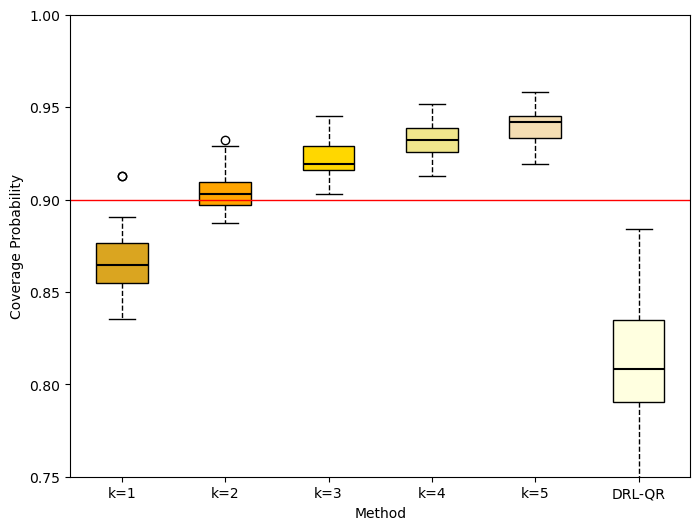

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

bplot_new_cov = data_new_rb_cov.boxplot(patch_artist=True,
                         medianprops={
                             'linestyle': '-',
                             'color': 'black',
                             'linewidth': 1.5
                         },
                         whiskerprops={
                             'linestyle': '--',
                             'color': 'black'
                         },
                         capprops={
                             'linestyle': '-',
                             'color': 'black'
                         },
                         boxprops={
                             'linestyle': '-',
                             'color': 'black'
                         })

colors = [
    'goldenrod', 'orange', 'gold', 'khaki', 'wheat', 'lightyellow','skyblue'
]

colors2 = [
    'darkseagreen','limegreen' ,'greenyellow','yellowgreen','lightgreen','honeydew','skyblue'
]
for patch, color in zip(bplot_new_cov.patches, colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1)

bplot_new_cov.yaxis.grid(False)
bplot_new_cov.xaxis.grid(False)
bplot_new_cov.set_xlabel("Method")
bplot_new_cov.set_ylabel("Coverage Probability")

plt.axhline(y=0.90, color='red', linestyle='-', linewidth=1)
#plt.title("tau=0.9, n_tr=600, gam=0.8, quantnum=30, p_s0 estimator")
plt.ylim(0.75,1)
#plt.savefig('fig/new_rb_cov_o_gam0.8_nr100_qnum10.png')
plt.savefig('Ex1_on_hd_cp.png')
plt.show()


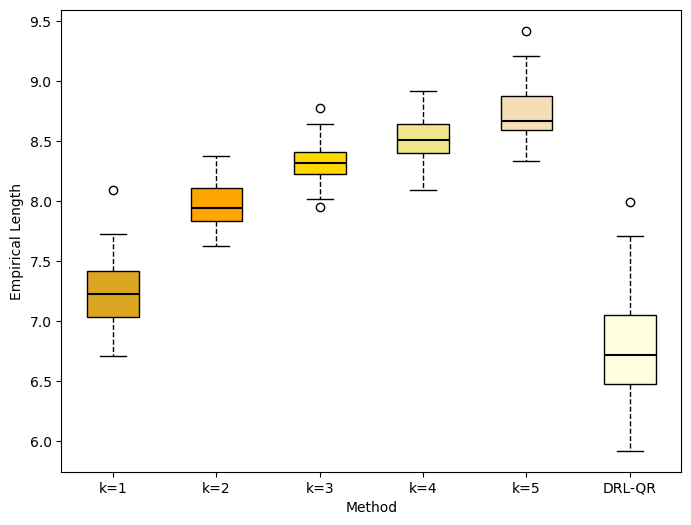

In [9]:
plt.figure(figsize=(8, 6))

bplot_new_len = data_new_rb_len.boxplot(patch_artist=True,
                         medianprops={
                             'linestyle': '-',
                             'color': 'black',
                             'linewidth': 1.5
                         },
                         whiskerprops={
                             'linestyle': '--',
                             'color': 'black'
                         },
                         capprops={
                             'linestyle': '-',
                             'color': 'black'
                         },
                         boxprops={
                             'linestyle': '-',
                             'color': 'black'
                         })


for patch, color in zip(bplot_new_len.patches, colors):
    patch.set_facecolor(color)
    patch.set_linewidth(1)

bplot_new_len.yaxis.grid(False)
bplot_new_len.xaxis.grid(False)
bplot_new_len.set_xlabel("Method")
bplot_new_len.set_ylabel("Empirical Length")

#plt.title("tau=0.9, n_tr = 600, gam=0.8, quantnum=30, p_s0 estimator")
#plt.savefig('fig/new_len_o_gam0.8_nr100_qnum10.png')
plt.savefig('Ex1_on_hd_al.png')
plt.show()
